# TensorFlow & Keras

Case study: We use regression to predict price from area.

## Setup

In [55]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing functions
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import StringLookup

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

print(tf.__version__)
sns.set_theme(style="ticks", color_codes=True)

2.7.1


## Data

### Import

- See notebook ["Data"](https://kirenz.github.io/regression/docs/case-duke-exploration.html) for details about data preprocessing

In [19]:
link = "https://raw.githubusercontent.com/kirenz/regression/main/_static/data/duke-data.csv"
df = pd.read_csv(link)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   price       97 non-null     int64  
 1   bed         97 non-null     int64  
 2   bath        97 non-null     float64
 3   area        97 non-null     int64  
 4   year_built  97 non-null     int64  
 5   cooling     97 non-null     object 
 6   lot         97 non-null     float64
dtypes: float64(2), int64(4), object(1)
memory usage: 5.4+ KB


### Data splitting

- Create data split: 

In [21]:
df_test = df.sample(frac=0.2, random_state=123)
df_train = df.drop(df_test.index)

In [22]:
print(
    "Using %d samples for training and %d for validation"
    % (len(df_train), len(df_test))
)

Using 78 samples for training and 19 for validation


### Transform to Tensors

- First, we define a function to create our tensors:

In [23]:
def dataframe_to_dataset(dataframe):
    dataframe = df.copy() # make a copy of your dataframe
    labels = dataframe.pop("price") # return label and drop from frame
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels)) # create tensor
    ds = ds.shuffle(buffer_size=len(dataframe)) #shuffle data
    return ds # return dataset

- Use function to create tensor data

In [24]:
ds_train = dataframe_to_dataset(df_train) # create train dataset
ds_test = dataframe_to_dataset(df_test) # create test dataset

- Let’s batch the datasets (combine some of our samples).

In [25]:
ds_train = ds_train.batch(32)
ds_test = ds_test.batch(32)

### Feature preprocessing

- Define numerical preprocessing function

In [26]:
def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a dataset that only yields our feature
    ds_feature = dataset.map(lambda x, y: x[name])
    ds_feature = ds_feature.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(ds_feature)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature

- Define categorical preprocessing function

In [27]:
def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    ds_feature = dataset.map(lambda x, y: x[name])
    ds_feature = ds_feature.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(ds_feature)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

- Define `keras.Input` for every feature:

- Numerical features

In [30]:
area = keras.Input(shape=(1,), name="area")

- Categorical features encoded as integers


In [ ]:
# none

- Categorical feature encoded as string

In [ ]:
# none

- Make a list of all keras.Input feature names

In [31]:
all_inputs = [
    area,
]

- Perform preprocessing

In [32]:
# Numerical features
area_encoded = encode_categorical_feature(area, "area", ds_train, False)

# Integer categorical features

# String categorical features



- Make a list of all the preprocessed features you want to use in your model

In [33]:
all_features = layers.concatenate(
    [
        area_encoded,
    ]
)

## Model

### Build

- Build the model

In [43]:
x = layers.Dense(1, activation="relu")(all_features)

x = layers.Dropout(0.2)(x)

output = layers.Dense(1)(x)

model = keras.Model(all_inputs, output)

### Compile

- Compile the model

In [44]:
model.compile(optimizer="adam", 
              loss ='mse', 
              metrics=[keras.metrics.RootMeanSquaredError()])

### Train

In [45]:
%%time

history = model.fit(ds_train, 
                    epochs=100, 
                    validation_data=ds_test, 
                    verbose=0)

/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['bed', 'bath', 'year_built', 'cooling', 'lot'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


CPU times: user 1.87 s, sys: 166 ms, total: 2.03 s
Wall time: 1.8 s


### Evaluate

In [60]:
model.evaluate(ds_test)

4/4 [==============================] - 0s 1ms/step - loss: 364866535424.0000 - root_mean_squared_error: 604041.8125


[364866535424.0, 604041.8125]

In [62]:
predictions = model.predict(ds_test)
predictions[3]

array([0.88366807], dtype=float32)

In [63]:
ds_test

<BatchDataset shapes: ({bed: (None,), bath: (None,), area: (None,), year_built: (None,), cooling: (None,), lot: (None,)}, (None,)), types: ({bed: tf.int64, bath: tf.float64, area: tf.int64, year_built: tf.int64, cooling: tf.string, lot: tf.float64}, tf.int64)>

In [52]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error,epoch
95,3.648666e+11,604041.8750,3.648666e+11,604041.8750,95
96,3.648665e+11,604041.8125,3.648666e+11,604041.8750,96
97,3.648665e+11,604041.8125,3.648665e+11,604041.8125,97
98,3.648665e+11,604041.7500,3.648665e+11,604041.7500,98
99,3.648665e+11,604041.7500,3.648665e+11,604041.7500,99


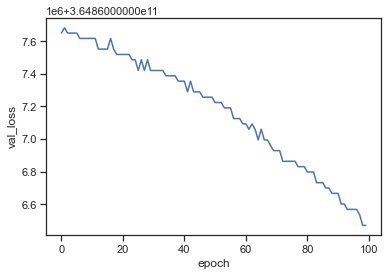

In [59]:
sns.lineplot(x="epoch", y="val_loss", data=hist);